In [1]:
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric



from sklearn.datasets import make_moons

from tqdm import tqdm

In [2]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input' 
# inpDir = Path('..') / '..' / 'input'
# # outDir = '../output'
# outDir = Path('..') / 'output'


RANDOM_STATE = 24 
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

TEST_SIZE  = 0.2 # Size of test data

NOISE = 0.2
N_SAMPLE = 1000
EPOCHS = 20001
ALPHA = 0.1


# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')


# numpy random set
rng = np.random.default_rng(seed=RANDOM_STATE)

In [3]:
X, y = make_moons(n_samples=N_SAMPLE, shuffle=True, noise=NOISE, random_state=RANDOM_STATE)

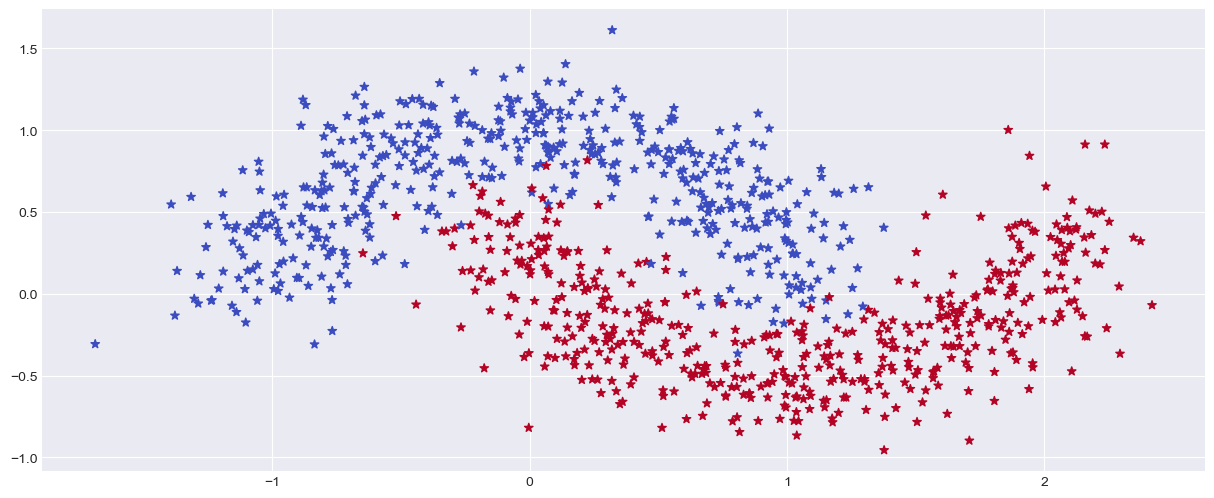

In [4]:
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, marker='*', cmap=CMAP)

In [5]:
data_df = pd.DataFrame(X, columns=['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


## SIGMOID

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [7]:
def fn_sigmoid(z: np.ndarray) -> float:
     return 1 / (1 + np.exp(-z))

In [8]:
def fn_activ(z):
    return np.tanh(z)

def fn_activ_prime(z):
    return 1.0 - np.tanh(z)**2

In [9]:
fn_activ(np.asarray([[-1,0,1],[-np.inf, 0, np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [10]:
sm = fn_sigmoid(np.asarray([-np.inf, -1,0, np.inf]))
sm

array([0.        , 0.26894142, 0.5       , 1.        ])

reshape y train as its 800 values are in a list

In [11]:
y_train = y_train.reshape(-1,1)
y_train.shape

(800, 1)

In [12]:
X.shape, y.shape

((1000, 2), (1000,))

In [13]:
def calculate_loss(model, X, y):
    W1 = model['W1']
    W2 = model['W2']
    b1 = model['b1']
    b2 = model['b2']
    m = X.shape[0]

    z1 = X.dot(W1) + b1 #aggregation
    a1 = fn_activ(z1) #activation

    z2 = a1.dot(W2) + b2 #aggregation
    a2 = fn_sigmoid(z2) #activation

    data_loss = -(y * np.log(a2) + (1-y) * np.log(1-a2)).sum()
    return data_loss/m

In [14]:
def predict(model, X):
    W1 = model['W1']
    W2 = model['W2']
    b1 = model['b1']
    b2 = model['b2']

    z1 = X.dot(W1) + b1 #aggregation
    a1 = fn_activ(z1) #activation

    z2 = a1.dot(W2) + b2 #aggregation
    a2 = fn_sigmoid(z2) #activation

    return a2 >= 0.5


In [21]:
loss_hist = {}
def build_model(nn_hdim, X, y, alpha, n_epoch):
    m, nn_input_dim = X.shape # same as number of features
    nn_output_dim = y.shape[1]
    W1 = rng.random((nn_input_dim, nn_hdim)) / np.sqrt(nn_input_dim)
    W2 = rng.random((nn_hdim, nn_output_dim)) / np.sqrt(nn_hdim)

    b1 = np.zeros((1,nn_hdim))
    b2 = np.zeros((1,nn_output_dim))

    loss, epoch = [], []

    for i in range(n_epoch):
# -----------> FORWARD PROPAGATION< -----------
        z1 = X.dot(W1) + b1 #aggregation
        a1 = fn_activ(z1) #activation

        z2 = a1.dot(W2) + b2 #aggregation
        a2 = fn_sigmoid(z2) #activation

 # -----------> BACKWARD PROPAGATION< -----------
        dz2 = a2 - y
        assert(z2.shape == dz2.shape), f'Shape z2: {z2.shape},{dz2.shape}'        

        dW2 = a1.T.dot(dz2)
        assert(W2.shape == dW2.shape), f'Shape W2: {W2.shape},{dW2.shape}'

        db2 = np.sum(dz2, axis=0, keepdims=True)
        assert(b2.shape == db2.shape), f'Shape b2: {b2.shape},{db2.shape}'

        da1 = dz2.dot(W2.T)
        assert(a1.shape == da1.shape),  f'Shape b2: {a1.shape},{da1.shape}'

        # LAYER 1
        dz1 = da1 * fn_activ_prime(z1)
        assert(z1.shape == dz1.shape),  f'Shape b2: {z1.shape},{dz1.shape}'

        dW1 = (X.T).dot(dz1)
        assert(W1.shape == dW1.shape), f'Shape b2: {W1.shape},{dW1.shape}'

        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert(b1.shape == db1.shape), f'Shape b2: {b1.shape},{db1.shape}'

        W1 = W1 - alpha * dW1 / m
        b1 = b1 - alpha * db1 / m
        W2 = W2 - alpha * dW2 / m
        b2 = b2 - alpha * db2 / m

    
        model = {'W1': W1, 'W2':W2, 'b1':b1, 'b2':b2}

        if i%1000 == 0:
            current_loss = calculate_loss(model, X,y)
            epoch.append(i)
            loss.append(current_loss)
            print(f'epoch - {epoch[-1]}: Loss: {current_loss}')

        
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss

    return model


In [27]:
model = build_model(2, X_train, y_train, alpha=ALPHA, n_epoch=EPOCHS)
model

epoch - 0: Loss: 0.6802185157208754
epoch - 1000: Loss: 0.29744917603997734
epoch - 2000: Loss: 0.2939762954738412
epoch - 3000: Loss: 0.29253943125324644
epoch - 4000: Loss: 0.2917764809764963
epoch - 5000: Loss: 0.2912768817837145
epoch - 6000: Loss: 0.2908953586789007
epoch - 7000: Loss: 0.29056477455945046
epoch - 8000: Loss: 0.29023951997431435
epoch - 9000: Loss: 0.2898737930164448
epoch - 10000: Loss: 0.2894109780241017
epoch - 11000: Loss: 0.28878735096949737
epoch - 12000: Loss: 0.28796233480442335
epoch - 13000: Loss: 0.28695301137668744
epoch - 14000: Loss: 0.2858296836558975
epoch - 15000: Loss: 0.28469344973357336
epoch - 16000: Loss: 0.28366141172963266
epoch - 17000: Loss: 0.28282951230162356
epoch - 18000: Loss: 0.2822268505307237
epoch - 19000: Loss: 0.2818201366764264
epoch - 20000: Loss: 0.28155386707707303


{'W1': array([[ 0.42338706,  0.83320612],
        [-1.52879447, -2.536939  ]]),
 'W2': array([[4.69838583],
        [3.59046997]]),
 'b1': array([[ 1.33552237, -1.77537356]]),
 'b2': array([[-0.43717855]])}

In [28]:
model['W1'].shape, model['W2'].shape, model['b1'].shape, model['b2'].shape

((2, 2), (2, 1), (1, 2), (1, 1))

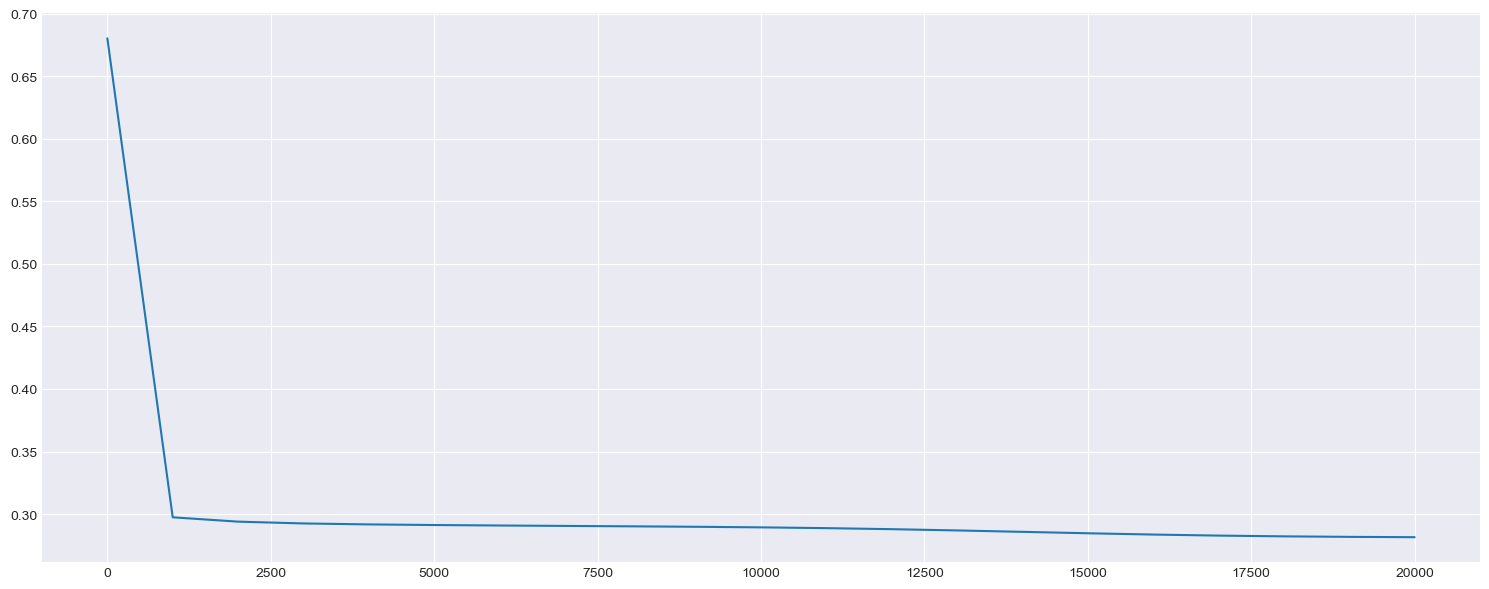

In [29]:
loss_df = pd.DataFrame(loss_hist)
fig, ax = plt.subplots()
ax.plot(loss_df['epoch'],loss_df['loss'])
plt.tight_layout()
plt.show()


In [30]:
def fn_plot_decision_boundary(X: np.ndarray, y: np.ndarray, model:dict, predict):
    
    # Initialize the figure with specified dimensions
    fig, ax = plt.subplots( figsize=(8, 5) )
    
    # Small increment value to create a fine grid for smooth decision boundary
    dm = 0.05
    padding = 2 * dm
    
    # Calculate the range for x-axis (first feature) with padding
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    
    # Calculate the range for y-axis (second feature) with padding  
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding
    
    # Create a mesh grid covering the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # Flatten the mesh grid arrays and stack them column-wise to create coordinate pairs
    XX = np.c_[xx.ravel(), yy.ravel()] # Resulting shape: (n_points, 2)

    # List to collect predictions for each point in the mesh grid
    y_pred = predict(model,XX)
        
    # Reshape predictions to match the original mesh grid dimensions
    Z = np.array(y_pred).reshape(xx.shape)

    # Create filled contour plot showing the decision regions
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    
    # Scatter plot of the actual data points, colored by their true class labels
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.bwr)
    
    # Set plot title and axis labels
    ax.set_title('Decision Boundary')
    ax.set_xlabel('A')  
    ax.set_ylabel('B') 
    
    # Display the final plot
    plt.show()

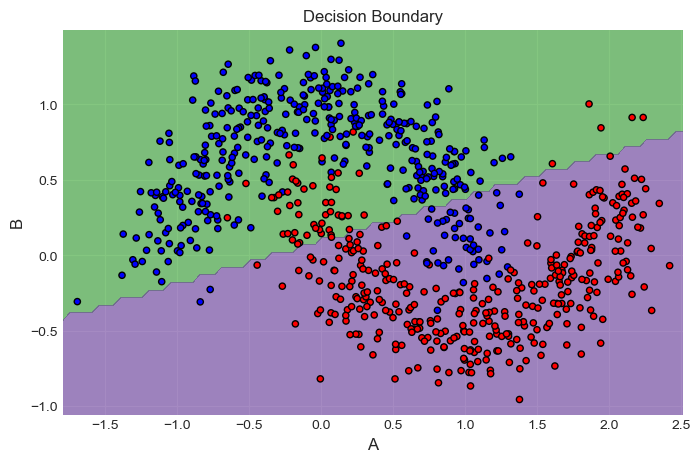

In [31]:
fn_plot_decision_boundary(X_train, y_train, model, predict)

## ASSIGNMENTS 1 & 2: EPOCHS, ALPHA 
#### Change them and see, intution on how things change when you change them
paste compare and make a note of the changes(not in submission just for you <3>)